In [84]:
import warnings
import itertools
import numpy as np
import io
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Load Data

In [85]:
link="/content/FIXDATA - Sheet1.csv"

df= pd.read_csv(link)

In [86]:
df.head()

,Rice_Price,Price_Date
0,6702.49,01-01-2010
1,6887.83,01-02-2010
2,6853.78,01-03-2010
3,6761.49,01-04-2010
4,6772.46,01-05-2010


In [87]:
df.Price_Date = pd.to_datetime(df.Price_Date, errors='coerce')

In [88]:
df=df.set_index('Price_Date')

In [89]:

df.head(2)

,Rice_Price
Price_Date,
2010-01-01,6702.49
2010-01-02,6887.83


In [90]:
data = df.copy()
y = data

In [91]:
y

,Rice_Price
Price_Date,
2010-01-01,6702.49
2010-01-02,6887.83
2010-01-03,6853.78
2010-01-04,6761.49
2010-01-05,6772.46
...,...
2022-01-05,12155.00
2022-01-06,12156.00
2022-01-07,12155.00


In [92]:
y = y['Rice_Price'].resample('MS').mean()
y = y.fillna(y.bfill())
print(y)

Price_Date
2010-01-01     7084.291667
2010-02-01     7889.841667
2010-03-01     7889.841667
2010-04-01     7889.841667
2010-05-01     7889.841667
                  ...     
2021-09-01    10831.572222
2021-10-01    10831.572222
2021-11-01    10831.572222
2021-12-01    10831.572222
2022-01-01    10831.572222
Freq: MS, Name: Rice_Price, Length: 145, dtype: float64


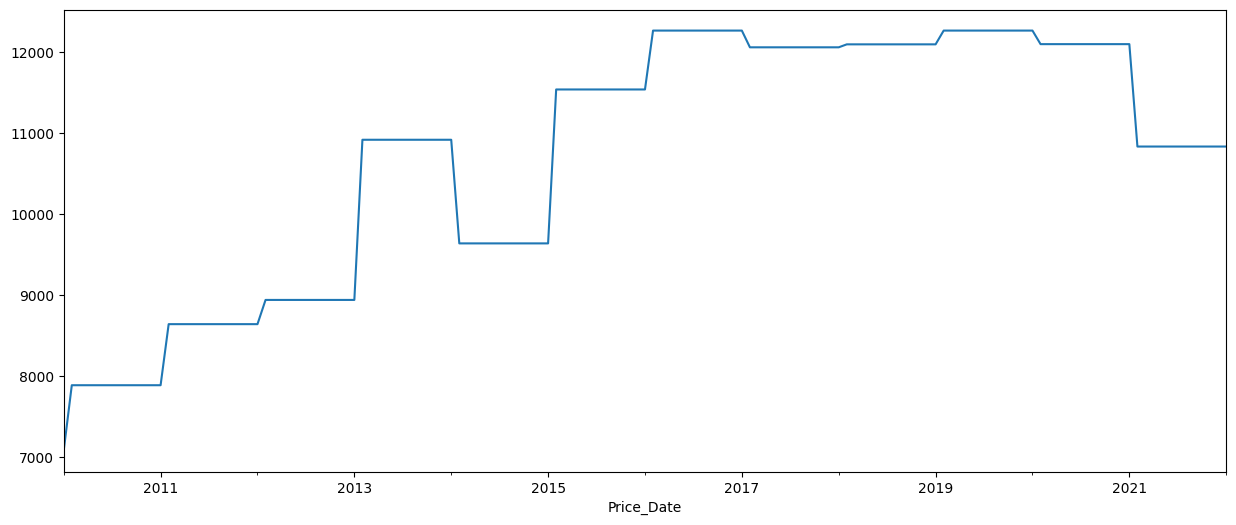

In [93]:
y.plot(figsize=(15, 6))
plt.show()

#Use ARIMA Model

In [94]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [95]:
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3087.2406379622007
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2749.1278431705014
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2211.769956809983
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2014.6348613933706
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2225.9394425134956
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2213.020160645531
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2027.3863959791024
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2010.6723010092896
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2965.0716112912337
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2694.4246578434527
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2086.7419536412353
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1895.6194245364002
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2119.567595374705
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2085.8454179808546
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1916.8560145575145
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1886.3917336125091
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2029.1252184308305
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1861.319104251

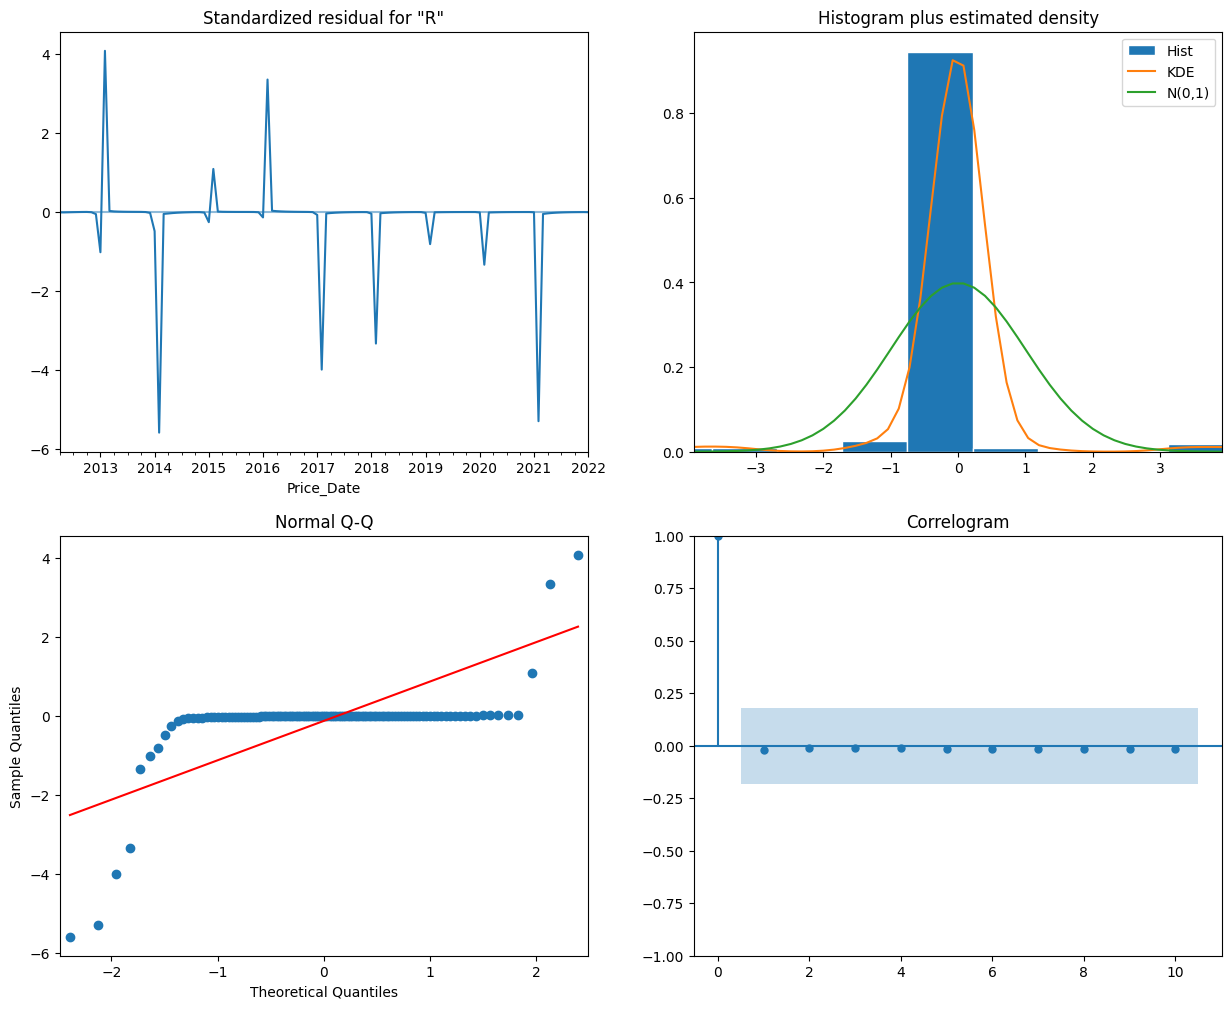

In [96]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [114]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()

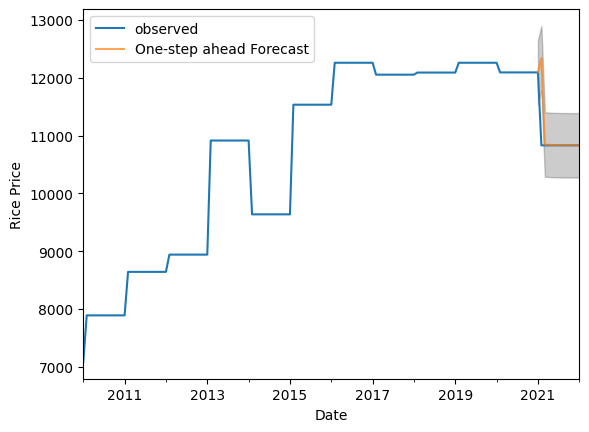

In [123]:
ax = y['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Rice Price')
plt.legend()
plt.show()

In [124]:
y_forecasted = pred.predicted_mean
y_truth = y['2021-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 175183.48


In [133]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

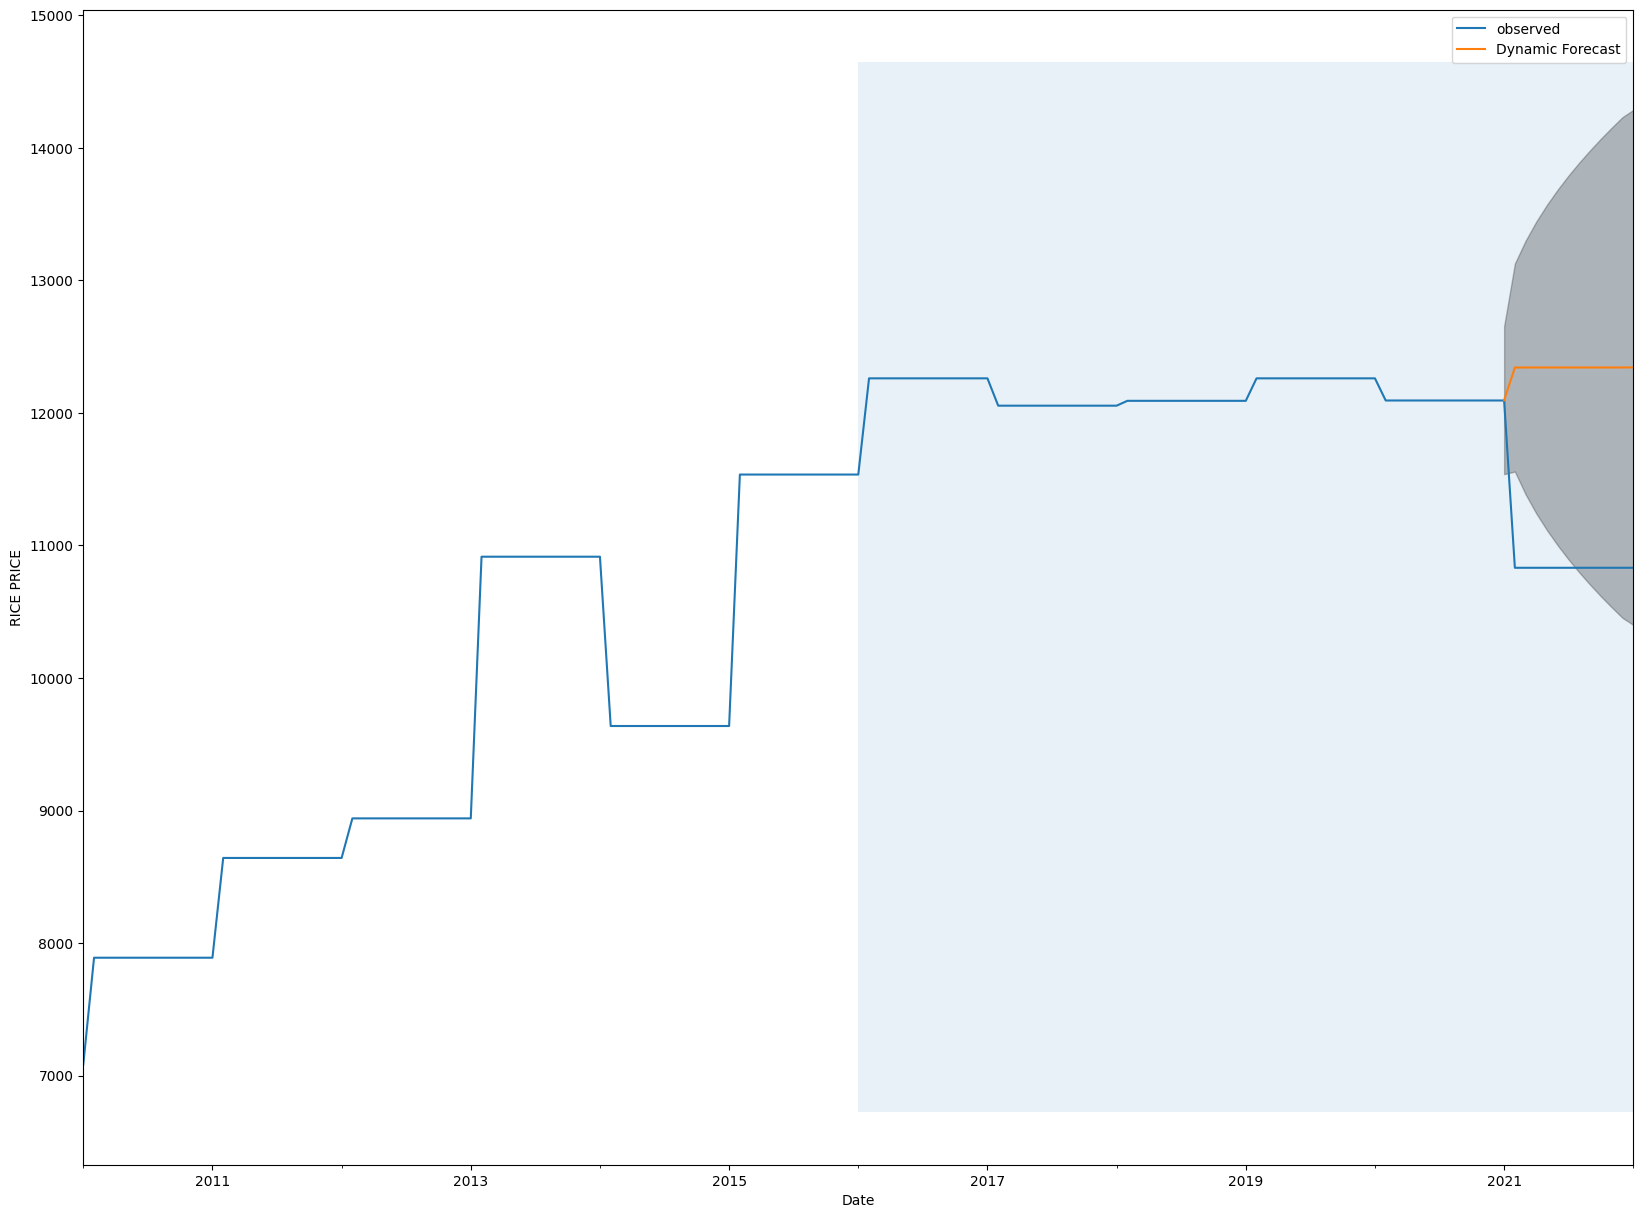

In [142]:
ax = y['2010':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('RICE PRICE')
plt.legend()
plt.show()

In [143]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2017-01-30':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2107584.34


In [144]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

In [145]:
pred_ci

,lower Rice_Price,upper Rice_Price
2022-02-01,10506.250531,11621.304340
2022-03-01,10279.170868,11848.740280
2022-04-01,10106.488922,12021.682503
2022-05-01,9961.725423,12166.627172
2022-06-01,9834.622233,12293.854748
2022-07-01,9719.941956,12408.619728
2022-08-01,9614.596198,12514.022481
2022-09-01,9516.590388,12612.065865
2022-10-01,9424.552131,12704.128782
2022-11-01,9337.493791,12791.209175


In [146]:
pred_ci.to_csv(r"predicted_RICE_price.csv")

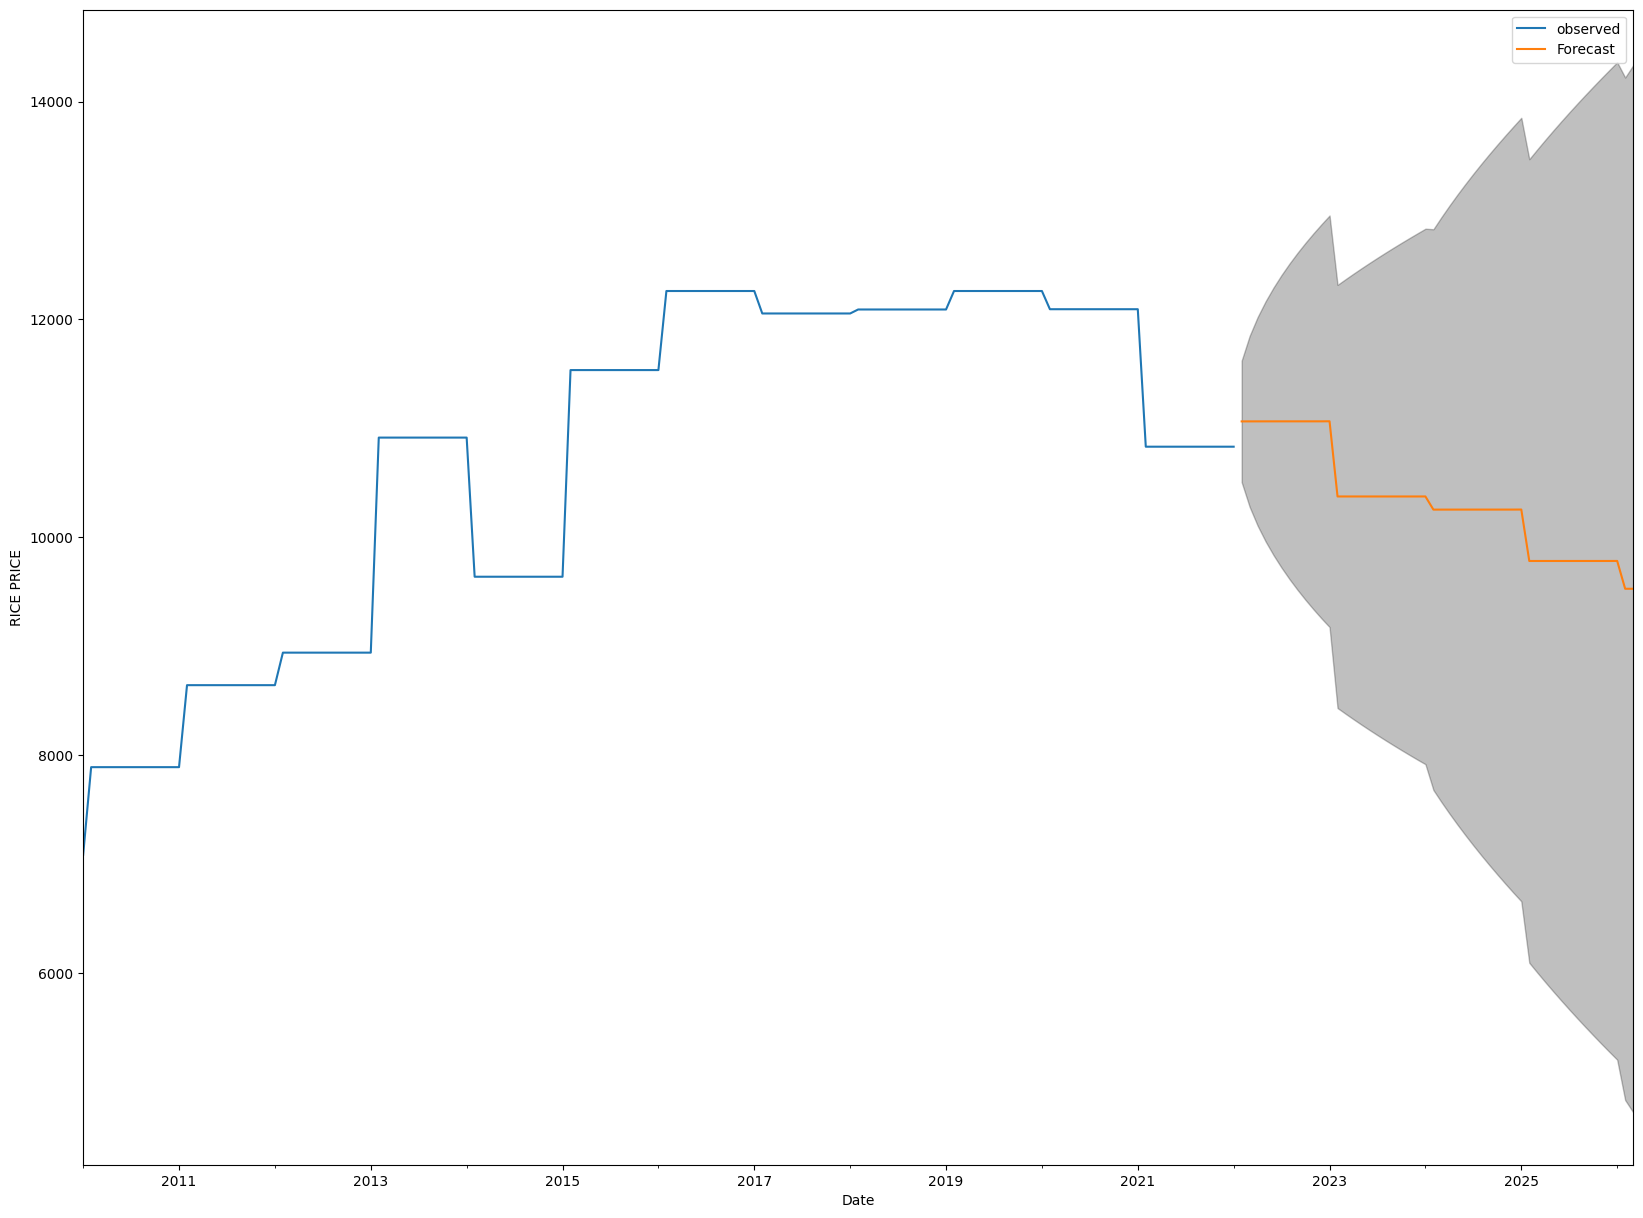

In [147]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('RICE PRICE')
plt.legend()
plt.show()